# 用 DoWhy 和 EconML 估计条件平均因果效应

条件平均因果效应(CATE) with DoWhy and EconML

这是一项实验性功能 where we use [EconML](https://github.com/microsoft/econml) methods from DoWhy. Using EconML allows CATE estimation using different methods. 

DoWhy中因果推理的所有四个步骤都保持不变：建模，识别，估计和反驳。
关键区别在于我们现在在估算步骤中调用econml方法。 还有一个使用线性回归的简单示例 to understand the intuition behind CATE estimators. 



In [1]:
import os, sys
sys.path.insert(1, os.path.abspath("../../../"))  # for dowhy source code

In [1]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy import CausalModel
import dowhy.datasets

import econml
import warnings
warnings.filterwarnings('ignore')

In [5]:
data = dowhy.datasets.linear_dataset(10, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                     num_treatments=1,
                                    treatment_is_binary=False,
#                                     num_discrete_common_causes=2,
#                                     num_discrete_effect_modifiers=0,
#                                     one_hot_encode=False
                                    )
df=data['df']
df.head()

X0        X1   Z0        Z1        W0        W1        W2        W3  \
0 -2.521464  0.155409  1.0  0.559138  2.007452  0.194488 -0.737834  0.949250   
1 -0.272124 -0.594038  0.0  0.562656  2.412827 -0.966005  1.208103 -0.916247   
2  1.471747  0.949394  0.0  0.537858  0.078511 -0.334681  1.886087 -0.414642   
3 -0.714296 -1.157574  1.0  0.650554 -0.396513  2.081661 -1.689673  0.317751   
4 -0.895241  0.463742  1.0  0.773794 -0.099374  0.707962  1.917918 -2.526865   

          v0           y  
0  18.744430  144.319845  
1   5.594197   56.033465  
2  10.707244  143.527164  
3  16.975189  130.548563  
4  16.929208  165.811436

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']


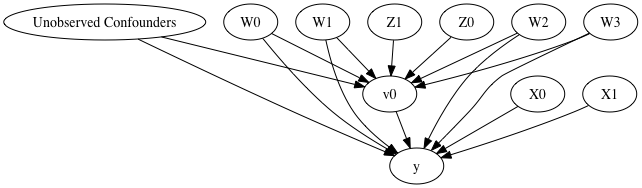

In [7]:
model = CausalModel(data=data["df"], 
                    treatment=data["treatment_name"], outcome=data["outcome_name"], 
                    graph=data["gml_graph"])

model.view_model()

from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [8]:
identified_estimand= model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['Unobserved Confounders', 'W0', 'W1', 'W3', 'W2']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z0', 'Z1']


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W0,W1,W3,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W3,W2,U) = P(y|v0,W0,W1,W3,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)



## 线性模型

首先，让我们使用线性模型建立一些直觉来估计CATE。可以将 effect modifiers（导致异质因果效应）建模为与 treatment 的交互项。因此，它们的值 modulates the effect of treatment. 

Below the estimated effect of changing treatment from 0 to 1.

In [9]:
linear_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate) 

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W1+W3+W2+v0*X1+v0*X0


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W0,W1,W3,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W3,W2,U) = P(y|v0,W0,W1,W3,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W0+W1+W3+W2+v0*X1+v0*X0
## Estimate
Value: 10.00000000000001



## EconML 方法

现在，我们从EconML包转向更高级的方法来估算CATE。


首先，让我们看一下 double machine learning estimator。Method_name 对应于我们要使用的类的标准名称。对于 double ML，它是“ econml.dml.DMLCateEstimator”。

Target units 定义了要计算因果估计的 units。 可以是 a lambda function filter on the original dataframe, a new Pandas dataframe, or a string corresponding to the three main kinds of target units ("ate", "att" and "atc"). 下面我们显示一个lambda函数的示例。

Method_params 是直接传参数给 EconML. 有关允许的参数的详细信息，请参阅EconML文档。

In [10]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DMLCateEstimator",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = lambda df: df["X0"]>1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W1+W3+W2
INFO:numexpr.utils:NumExpr defaulting to 4 threads.


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W0,W1,W3,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W3,W2,U) = P(y|v0,W0,W1,W3,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W0+W1+W3+W2
## Estimate
Value: 12.377928464975215



In [11]:
print("True causal estimate is", data["ate"])

True causal estimate is 9.978706628277308


In [12]:
dml_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DMLCateEstimator",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(dml_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W1+W3+W2


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W0,W1,W3,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W3,W2,U) = P(y|v0,W0,W1,W3,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W0+W1+W3+W2
## Estimate
Value: 9.919618287281304



### CATE Object 和置信区间

In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DMLCateEstimator",
                                     target_units = lambda df: df["X0"]>1, 
                                     confidence_intervals=True,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{
                                                               'inference': 'bootstrap',
                                                            }
                                              })
print(dml_estimate)
print(dml_estimate.cate_estimates[:10])
print(dml_estimate.effect_intervals)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W1+W3+W2
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.1s finished


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W0,W1,W3,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W3,W2,U) = P(y|v0,W0,W1,W3,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W0+W1+W3+W2
## Estimate
Value: 12.29197180689786

[[13.07887647]
 [10.77809375]
 [13.71470538]
 [12.2937543 ]
 [11.72053516]
 [10.7891811 ]
 [12.77571337]
 [13.15299296]
 [12.73256256]
 [ 9.99162377]]
(array([[12.87146448],
       [10.63969365],
       [13.49162136],
       [12.10427793],
       [11.55423673],
       [10.65016767],
       [12.536533

### New inputs 的因果效应

Can provide a new inputs as target units and estimate CATE on them.

In [14]:
test_cols= data['effect_modifier_names'] # only need effect modifiers' values
test_arr = [np.random.uniform(0,1, 10) for _ in range(len(test_cols))] # all variables are sampled uniformly, sample of 10
test_df = pd.DataFrame(np.array(test_arr).transpose(), columns=test_cols)
dml_estimate = model.estimate_effect(identified_estimand, 
                                     method_name="backdoor.econml.dml.DMLCateEstimator",
                                     target_units = test_df,
                                     confidence_intervals=False,
                                     method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(), 
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}
                                              })
print(dml_estimate.cate_estimates)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W1+W3+W2


[[12.16905407]
 [10.42165624]
 [10.67733797]
 [11.62091416]
 [10.98568175]
 [12.5880907 ]
 [10.96991444]
 [10.46498503]
 [10.6584332 ]
 [11.35387743]]


我们可以取出原始 EconML estimator 对象以进行任何进一步的操作。

In [16]:
print(dml_estimate._estimator_object)
dml_estimate

## Works with any EconML method

In addition to double machine learning, below we example analyses using orthogonal forests, DRLearner (bug to fix), and neural network-based instrumental variables. 

除了 double machine learning 之外，below we example analyses using 正交森林，DRLearner (bug to fix) 和基于神经网络的工具变量法等。

### Continuous treatment, Continuous outcome

正交森林方法， orthogonal forests

In [17]:
from sklearn.linear_model import LogisticRegression
orthoforest_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.econml.ortho_forest.ContinuousTreatmentOrthoForest",
                                 target_units = lambda df: df["X0"]>1, 
                                 confidence_intervals=False,
                                method_params={"init_params":{
                                                    'n_trees':2, # not ideal, just as an example to speed up computation
                                                    },
                                               "fit_params":{}
                                              })
print(orthoforest_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W1+W3+W2
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   14.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   14.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.9s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   13.9s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  1.1min


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W0,W1,W3,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W3,W2,U) = P(y|v0,W0,W1,W3,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W0+W1+W3+W2
## Estimate
Value: 12.077425164170238



[Parallel(n_jobs=-1)]: Done 465 out of 465 | elapsed:  1.8min finished


### Binary treatment, Binary outcome

 DRLearner estimator

In [18]:
data_binary = dowhy.datasets.linear_dataset(10, num_common_causes=4, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=2,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_binary['df'].v0 = data_binary['df'].v0.astype(int)
data_binary['df'].y = data_binary['df'].y.astype(int)
print(data_binary['df'])

model_binary = CausalModel(data=data_binary["df"], 
                    treatment=data_binary["treatment_name"], outcome=data_binary["outcome_name"], 
                    graph=data_binary["gml_graph"])
identified_estimand_binary = model_binary.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['Unobserved Confounders', 'W0', 'W1', 'W3', 'W2']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z0', 'Z1']


            X0        X1   Z0        Z1        W0        W1        W2  \
0     0.143737  0.895689  1.0  0.633470  1.228916  1.122003 -0.103196   
1     0.027461 -0.842702  1.0  0.395361  1.830941  0.664096 -0.069751   
2    -1.092524  0.863230  1.0  0.575361  2.094211  0.111609 -0.890925   
3     0.226557  2.270647  0.0  0.779255  0.270405  0.359455  0.600549   
4    -1.279422  0.610456  0.0  0.920709  1.630068  3.144059 -1.046812   
...        ...       ...  ...       ...       ...       ...       ...   
9995  1.920812  0.445518  1.0  0.423858  1.369760  0.553453  0.824119   
9996  0.867758  0.790538  1.0  0.937978  2.061503  1.310532 -0.221242   
9997  1.106002 -0.406379  0.0  0.609452  0.639231 -1.214904  1.988916   
9998  0.899491 -0.195329  0.0  0.872710  1.686182  0.795478 -2.904364   
9999  1.099352  0.960848  1.0  0.248887  0.465099  1.360711 -2.091084   

            W3  v0  y  
0    -0.759881   1  1  
1    -1.512547   1  0  
2    -0.388786   1  1  
3     1.460291   1  1  
4  

使用 DRLearner estimator

In [19]:
from sklearn.linear_model import LogisticRegressionCV
#todo needs binary y
drlearner_estimate = model_binary.estimate_effect(identified_estimand_binary, 
                                method_name="backdoor.econml.drlearner.LinearDRLearner",
                                target_units = lambda df: df["X0"]>1, 
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'model_propensity': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(drlearner_estimate)

INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W1+W3+W2


*** Causal Estimate ***

## Target estimand
Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                              
─────(Expectation(y|W0,W1,W3,W2))
d[v₀]                            
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,W1,W3,W2,U) = P(y|v0,W0,W1,W3,W2)
### Estimand : 2
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, [Z0, Z1])*Derivative([v0], [Z0, Z1])**(-1))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z0,Z1})
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→{v0}, then ¬({Z0,Z1}→y)

## Realized estimand
b: y~v0+W0+W1+W3+W2
## Estimate
Value: 0.17287242432807604



### 工具变量法

In [20]:
import keras
from econml.deepiv import DeepIVEstimator
dims_zx = len(model._instruments)+len(model._effect_modifiers)
dims_tx = len(model._treatment)+len(model._effect_modifiers)
treatment_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_zx,)), # sum of dims of Z and X 
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17)])                
response_model = keras.Sequential([keras.layers.Dense(128, activation='relu', input_shape=(dims_tx,)), # sum of dims of T and X
                                    keras.layers.Dropout(0.17), 
                                    keras.layers.Dense(64, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(32, activation='relu'),
                                    keras.layers.Dropout(0.17),
                                    keras.layers.Dense(1)])

deepiv_estimate = model.estimate_effect(identified_estimand, 
                                        method_name="iv.econml.deepiv.DeepIVEstimator",
                                        target_units = lambda df: df["X0"]>-1, 
                                        confidence_intervals=False,
                                method_params={"init_params":{'n_components': 10, # Number of gaussians in the mixture density networks
                                                              'm': lambda z, x: treatment_model(keras.layers.concatenate([z, x])), # Treatment model,
                                                              "h": lambda t, x: response_model(keras.layers.concatenate([t, x])), # Response model
                                                              'n_samples': 1, # Number of samples used to estimate the response
                                                              'first_stage_options': {'epochs':25},
                                                              'second_stage_options': {'epochs':25}
                                                             },
                                               "fit_params":{}})
print(deepiv_estimate)

Using TensorFlow backend.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:dowhy.causal_estimator:INFO: Using EconML Estimator
INFO:dowhy.causal_estimator:b: y~v0+W0+W1+W3+W2
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/25
10000/10000 [==============================] - 1s 136us/step - loss: 4.9846
Epoch 2/25
10000/10000 [==============================] - 1s 74us/step - loss: 2.8016
Epoch 3/25
10000/10000 [==============================] - 1s 74us/step - loss: 2.6807
Epoch 4/25
10000/10000 [==============================] - 1s 75us/step - loss: 2.6352
Epoch 5/25
10000/10000 [==============================] - 1s 86us/step - loss: 2.6195
Epoch 6/25
10000/10000 [==============================] - 1s 77us/step - loss: 2.5961
Epoch 7/25
10000/10000 [==============================] - 1s 78us/step - loss: 2.5861
Epoch 8/25
10000/10000 [==============================] - 1s 85us/step - loss: 2.5722
Epoch 9/25
10000/10000 [==============================] - 1s 75us/step - loss: 2.5690
Epoch 10/25
10000/10000 [==============================] - 1s 97us/step - loss: 2.5555
Epoch 11/25
10000/10000 [==============================] - 1s 89us/step - loss: 2.5486
Epoch 12/25
10000/10000 [==========================

### Metalearners

In [21]:
data_experiment = dowhy.datasets.linear_dataset(10, num_common_causes=0, num_samples=10000,
                                    num_instruments=2, num_effect_modifiers=4,
                                    treatment_is_binary=True, outcome_is_binary=True)
# convert boolean values to {0,1} numeric
data_experiment['df'].v0 = data_experiment['df'].v0.astype(int)
data_experiment['df'].y = data_experiment['df'].y.astype(int)
print(data_experiment['df'])

model_experiment = CausalModel(data=data_experiment["df"], 
                    treatment=data_experiment["treatment_name"], outcome=data_experiment["outcome_name"], 
                    graph=data_experiment["gml_graph"])
identified_estimand_experiment = model_experiment.identify_effect(proceed_when_unidentifiable=True)

INFO:dowhy.causal_model:Model to find the causal effect of treatment ['v0'] on outcome ['y']
INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['Unobserved Confounders']
INFO:dowhy.causal_identifier:Continuing by ignoring these unobserved confounders because proceed_when_unidentifiable flag is True.
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z0', 'Z1']


            X0        X1        X2        X3   Z0        Z1  v0  y
0     0.995605  2.013543  1.910889  0.501417  1.0  0.905808   1  0
1    -1.607226 -0.927225 -0.831809 -2.579346  0.0  0.003871   0  0
2    -1.542529 -2.111406  0.482695  0.669389  1.0  0.135426   1  0
3    -1.833528  0.065794 -1.490086 -1.895976  0.0  0.847716   1  0
4    -1.760129 -1.348228  2.084825  1.365359  0.0  0.248994   1  1
...        ...       ...       ...       ...  ...       ...  .. ..
9995 -0.355503 -1.634357  0.915420  0.189763  0.0  0.956708   1  1
9996 -0.077529 -1.898474 -0.963058  0.126657  1.0  0.794665   1  1
9997 -0.157876 -0.812651  2.003876 -0.850003  1.0  0.708076   1  1
9998 -2.744425 -3.038899 -0.061868  0.242013  0.0  0.792547   1  1
9999 -1.211644  0.422355  0.996183  0.798486  0.0  0.996503   1  0

[10000 rows x 8 columns]


In [ ]:
from sklearn.linear_model import LogisticRegressionCV
metalearner_estimate = model_experiment.estimate_effect(identified_estimand_experiment, 
                                method_name="backdoor.econml.metalearners.TLearner",
                                target_units = lambda df: df["X0"]>1, 
                                confidence_intervals=False,
                                method_params={"init_params":{
                                                    'models': LogisticRegressionCV(cv=3, solver='lbfgs', multi_class='auto')
                                                    },
                                               "fit_params":{}
                                              })
print(metalearner_estimate)

## Refuting the estimate

### Random 

In [ ]:
res_random=model.refute_estimate(identified_estimand, dml_estimate, method_name="random_common_cause")
print(res_random)

### Adding an unobserved common cause variable

In [ ]:
res_unobserved=model.refute_estimate(identified_estimand, dml_estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="linear", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

### Replacing treatment with a random (placebo) variable

In [ ]:
res_placebo=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

### Removing a random subset of the data

In [ ]:
res_subset=model.refute_estimate(identified_estimand, dml_estimate,
        method_name="data_subset_refuter", subset_fraction=0.8)
print(res_subset)

More refutation methods to come, especially specific to the CATE estimators.